In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.tri as tri
from shapely.geometry import Point # PARA INSTALAR ESCRIBIR EN ANACONDA PROMPT: conda install shapely --channel=conda-forge
from shapely.geometry import Polygon
from shapely.ops import unary_union
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [2]:
Nodespack = pd.read_pickle(r'C:\Users\ntasso\Google Drive Streaming\My Drive\!Charlas\!UNAM - Flujo en triaxial CIUC\!Codes\Data\HSS - K0 - FC5s - MeshFine - KE-04\undrained-Nodes.pkl')
StressPointspack = pd.read_pickle(r'C:\Users\ntasso\Google Drive Streaming\My Drive\!Charlas\!UNAM - Flujo en triaxial CIUC\!Codes\Data\HSS - K0 - FC5s - MeshFine - KE-04\undrained-StressPoints.pkl')
TRX = pd.read_pickle(r'C:\Users\ntasso\Google Drive Streaming\My Drive\!Charlas\!UNAM - Flujo en triaxial CIUC\!Codes\Data\HSS - K0 - FC5s - MeshFine - KE-04\undrained-TRX.pkl')

In [3]:
def interp_in_SP(Nodes,StressPoints,scale=1):
    interp_ux = LinearNDInterpolator(list(zip(Nodes['X'], Nodes['Y'])), Nodes['ux'])
    interp_uy = LinearNDInterpolator(list(zip(Nodes['X'], Nodes['Y'])), Nodes['uy'])
    interp_eps = LinearNDInterpolator(list(zip(Nodes['X'], Nodes['Y'])), Nodes['eps_y'])


    # Make a copy of stresspoints
    B = StressPoints.copy()

    # Create ux and uy columns in stresspoints dict
    B['ux']= interp_ux(StressPoints['X'], StressPoints['Y'])
    B['uy']= interp_uy(StressPoints['X'], StressPoints['Y'])
    B['eps_y'] = interp_eps(StressPoints['X'], StressPoints['Y'])

    # Create new positions of X and Y
    B['newX'] = B['X']+B['ux']*scale
    B['newY'] = B['Y']+B['uy']*scale
    return B

In [4]:
def clusterinsideplot(Dat,TypeElement,scale=1):
    total = Polygon()
    xp = Dat['X'].values+Dat['ux'].values*scale
    yp = Dat['Y'].values+Dat['uy'].values*scale
 
    Q = {}
    for i in range(0,len(xp)-2,TypeElement):
        Q[str(i)] = Polygon(zip(xp[i:i+3],yp[i:i+3])).buffer(0.00001)
        
    matpol = unary_union([Q[p] for p in Q])

    return matpol

In [5]:
def calculate_alpha(Qmod,Qmax):
    x = np.log10(Qmod/Qmax)
    alpha = (x+4)/(0+4)*0.01
    # alpha = (1 - (Qmax-Qmod)/Qmax)*0.01*0.9

    # print(alpha,x)
    alpha = max(alpha,0)
    # alpha = min(alpha,0.01)
    # print(alpha)
    return alpha

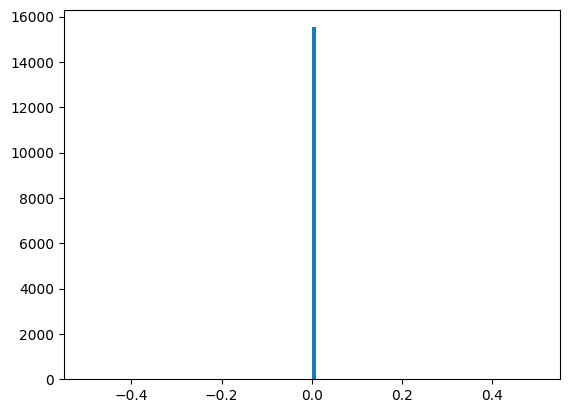

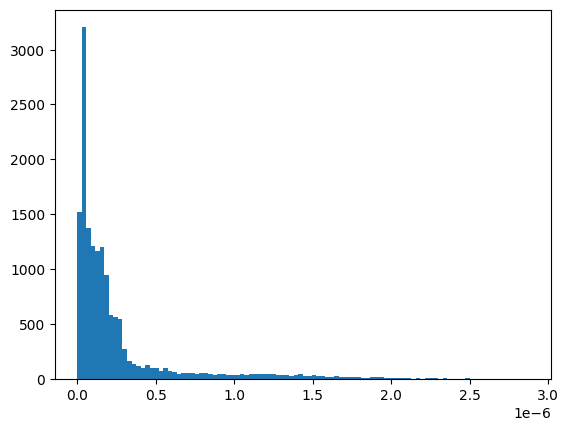

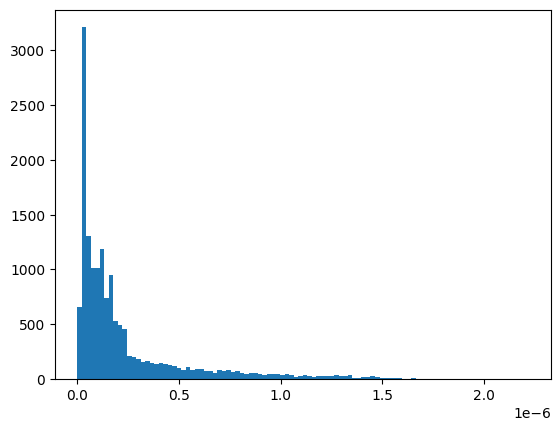

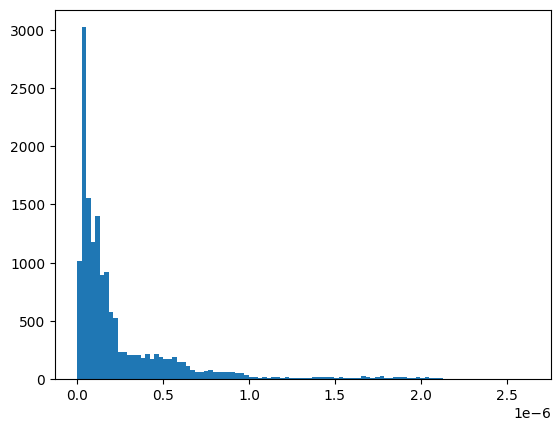

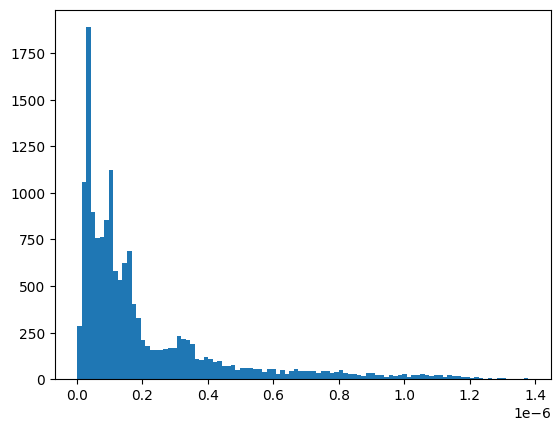

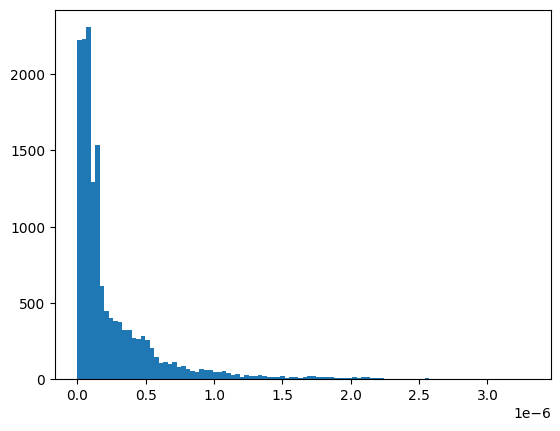

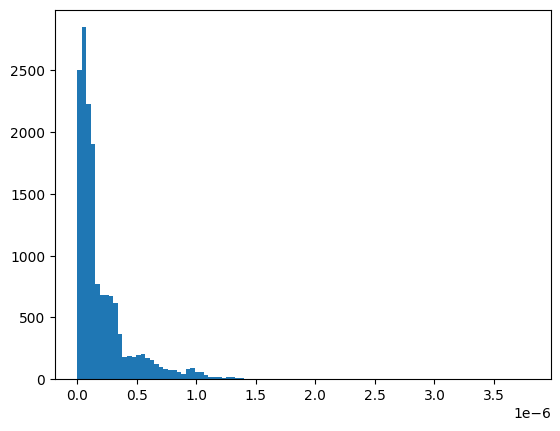

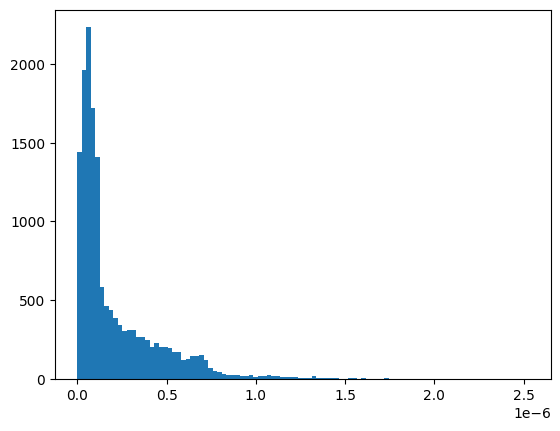

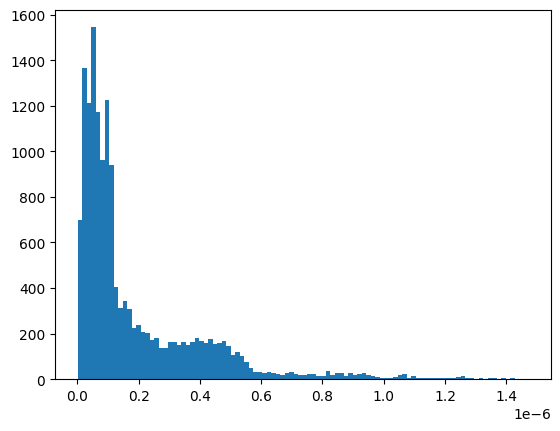

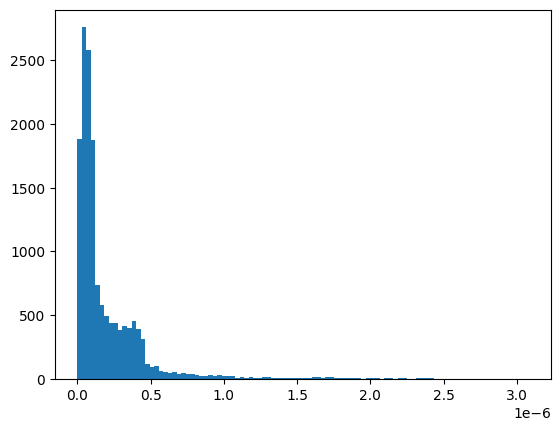

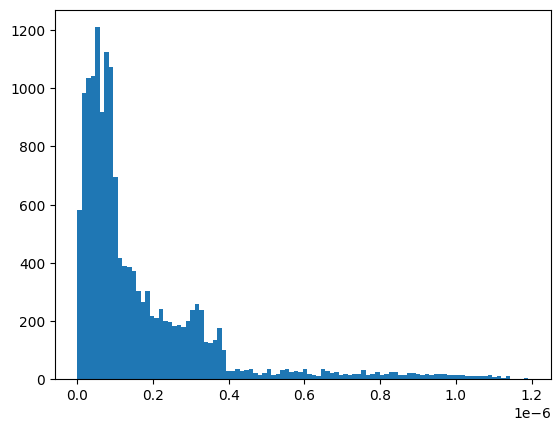

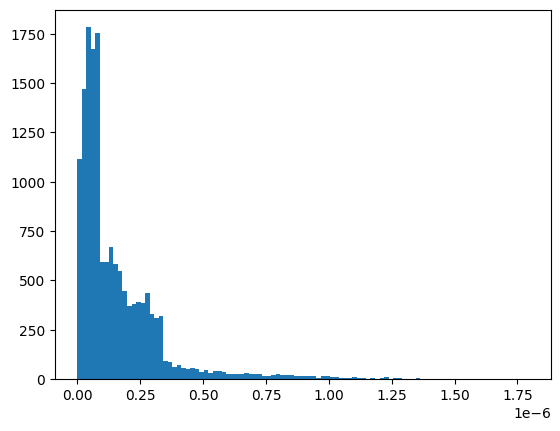

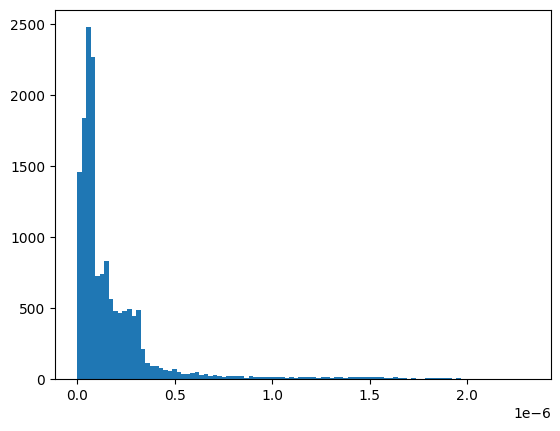

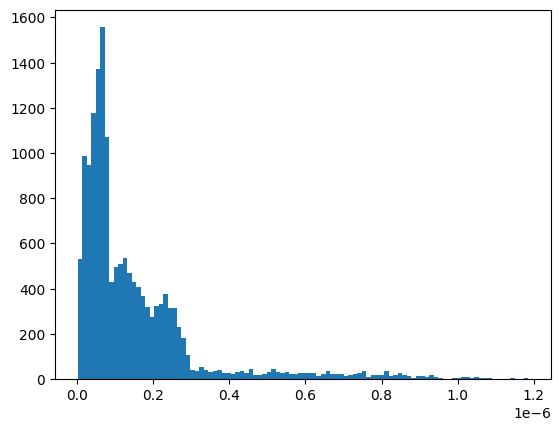

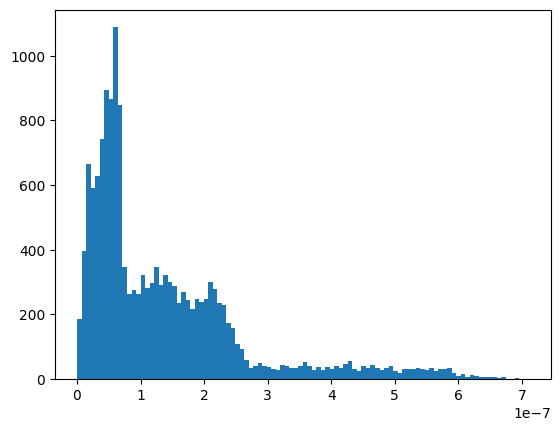

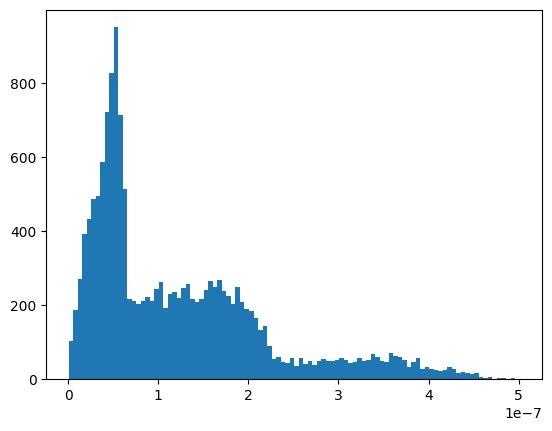

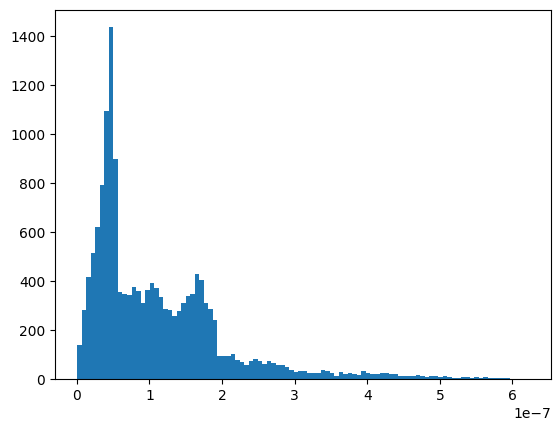

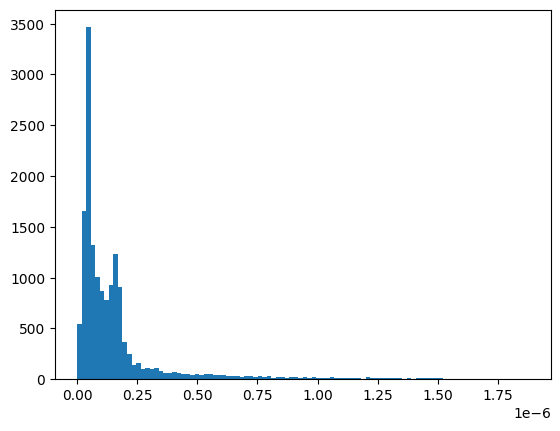

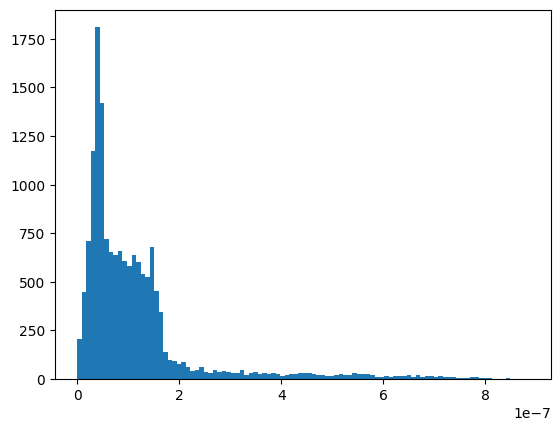

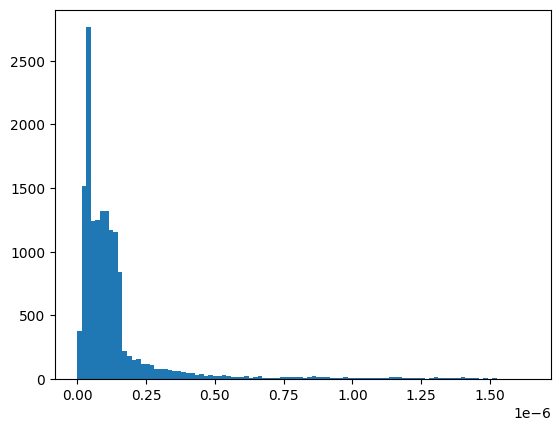

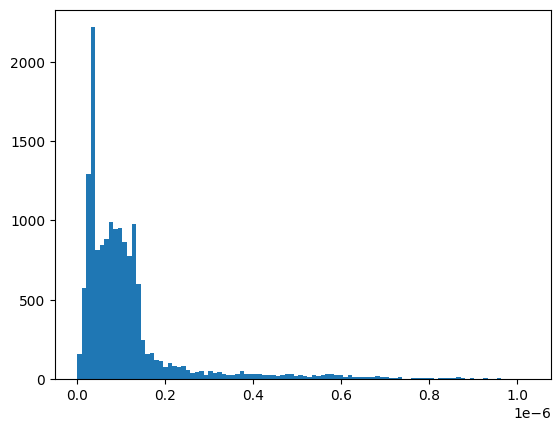

In [6]:
Qmax = 0
for SPidx in range(0,len(StressPointspack),30):
    SPidx = int(SPidx)
    Qmax=max(Qmax,StressPointspack[SPidx]['FlowField'].max())
    plt.hist(StressPointspack[SPidx]['FlowField'],bins=100)
    plt.show()

# print(Qmax)
# plt.hist(Qmax,bins=100)

In [8]:
def Plot_PExcess(Nodes,StressPoints,axes,var,cdiv_value=10,cm='jet_r',cmin=-100,cmax=0,cextend='both',n_elements=15,scale=1,clabel='PExcess'):
        # triangulate coordinates
        triangmask = tri.Triangulation(np.array(StressPoints['newX'].values),np.array(StressPoints['newY'].values))

        # plot contour map
        cont = axes.tricontourf(triangmask, StressPoints[var], cdiv_value,cmap=cm, levels=np.linspace(cmin,cmax,cdiv_value), zorder=2,extend=cextend)

        # apply patch
        polygon = clusterinsideplot(Nodes,n_elements,scale=scale)
        External_boundary = {}
        External_boundary['x'],External_boundary['y'] = polygon.exterior.coords.xy
        clippath = Path(np.c_[External_boundary['x'], External_boundary['y']])
        patch = PathPatch(clippath, facecolor='none')
        axes.add_patch(patch)
        for c in cont.collections:
                c.set_clip_path(patch)

        # plot external boundary
        axes.plot(External_boundary['x'],External_boundary['y'],color='k')

        # # plot cbar
        cbar = plt.colorbar(cont,ax=axes, pad=0.05, aspect=10, ticks=np.linspace(cmin,cmax,cdiv_value),extend=cextend)
        cbar.set_label(clabel, rotation=270, labelpad=10)


def Plot_Flow(Nodes,StressPoints,axes,var,cdiv_value=10,cm='jet_r',cmin=-100,cmax=0,cextend='both',n_elements=15,scale=1,clabel='PExcess'):
        # triangulate coordinates
        triangmask = tri.Triangulation(np.array(StressPoints['newX'].values),np.array(StressPoints['newY'].values))

        # plot contour map
        # cont = axes.tricontourf(triangmask, StressPoints[], cdiv_value,cmap=cm, levels=np.linspace(cmin,cmax,cdiv_value), zorder=2,extend=cextend)

        # apply patch
        polygon = clusterinsideplot(Nodes,n_elements,scale=scale)
        External_boundary = {}
        External_boundary['x'],External_boundary['y'] = polygon.exterior.coords.xy
        # clippath = Path(np.c_[External_boundary['x'], External_boundary['y']])
        # patch = PathPatch(clippath, facecolor='none')
        # axes.add_patch(patch)
        # for c in cont.collections:
        #         c.set_clip_path(patch)

        # plot external boundary
        axes.plot(External_boundary['x'],External_boundary['y'],color='k')
        # print(StressPoints['FlowField'].max())
        for i in range(0,len(StressPoints),5):
                
                Qmod = StressPoints['FlowField'].values[i]
                alphaid = calculate_alpha(Qmod,1e-6)*1e5

                headscale = Qmod*alphaid*0.5
                # alphaid/0.001/0.01
                # headscale = alphaid/0.001/0.01                # headscale=0.01
                # headscale = min(headscale,0.00025/0.001)
                # print(headscale)
                axes.arrow(StressPoints['newX'].values[i],StressPoints['newY'].values[i],StressPoints['Qx'].values[i]*alphaid,StressPoints['Qy'].values[i]*alphaid,color='b',alpha=0.5,head_width=headscale,head_length=headscale,width=headscale*0.1)
        # # plot cbar
        # cbar = plt.colorbar(cont,ax=axes, pad=0.05, aspect=10, ticks=np.linspace(cmin,cmax,cdiv_value),extend=cextend)
        # cbar.set_label(clabel, rotation=270, labelpad=10)

In [12]:
for step in range(len(StressPointspack)):
    print(step)
    # step = 5
    # if step >66:
        
    fig = plt.figure(figsize=(15,6))

    axes = {}
    axes[0] = plt.subplot(131)
    axes[0].set_axis_off()
    axes[0].set_xlim(-0.005,0.055)
    axes[0].set_ylim(-0.005,0.105)
    axes[1] = plt.subplot(132)
    axes[1].set_axis_off()
    axes[1].set_xlim(-0.005,0.055)
    axes[1].set_ylim(-0.005,0.105)
    axes[2] = plt.subplot(133)
    axes[2].set_xlim(-0.005,0.067)
    axes[2].set_ylim(-0.005,0.105)
    axes[2].set_axis_off()

    Nodes = Nodespack[step]
    scale = 1
    StressPoints = interp_in_SP(Nodes,StressPointspack[step],scale=scale)
    var = 'Deltau'
    Plot_PExcess(Nodes,StressPoints,axes[0],var,cdiv_value=10,cm='jet_r',cmin=-100,cmax=10,cextend='min',n_elements=15,scale=scale,clabel='$\Delta u$ [kPa]')
    var = 'FlowField'
    
    Plot_PExcess(Nodes,StressPoints,axes[1],var,cdiv_value=10,cm='jet_r',cmin=1e-8,cmax=1e-6,cextend='both',n_elements=15,scale=scale,clabel='$|q|$ [m/s2/m]')
       
    Plot_Flow(Nodes,StressPoints,axes[2],var,cdiv_value=10,cm='jet_r',cmin=-100,cmax=0,cextend='both',n_elements=15,scale=1,clabel='PExcess')
    # plt.show()

    axes[0].set_title('Excess pore pressure',fontsize=20)
    axes[1].set_title('Flow field',fontsize=20)
    axes[2].set_title('Flow field direction     ',fontsize=20)
    fig.savefig(str(step)+'.jpg',bbox_inches='tight',dpi=300)
    plt.clf()
    plt.close()
    # break

0


C:\Users\ntasso\AppData\Local\Temp\ipykernel_29628\4195413423.py:2: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(Qmod/Qmax)


1


C:\Users\ntasso\AppData\Local\Temp\ipykernel_29628\4195413423.py:2: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(Qmod/Qmax)


2


C:\Users\ntasso\AppData\Local\Temp\ipykernel_29628\4195413423.py:2: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(Qmod/Qmax)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
